In [26]:
import numpy as np
from pyspeckit.spectrum.models import lte_molecule
from pyspeckit.spectrum.models.lte_molecule import get_molecular_parameters
from astroquery.linelists.cdms import CDMS
import astropy.units as u
import matplotlib.pyplot as plt
from astroquery.splatalogue import utils, Splatalogue
import scipy.constants as cnst
from astropy.io import fits
import glob
from astropy.modeling import models#Fittable1DModel, Parameter, fitting
from utilities import *#Q_rot_asym,mulu,vradio,t_rad,nupper_estimated,opticaldepth,qngrabber
import matplotlib as mpl
import pdb
import sys
from manualspeciesabundances import *
from spectral_cube import SpectralCube as sc

freq_min=216.4580088699714*u.GHz
freq_max=218.3329843585865*u.GHz
molecule=' CH3OCHO '
jpl_catdir=JPLSpec.get_species_table()
cdms_catdir=CDMS.get_species_table()

In [27]:
molname=jplnamelist[molecule]
cCfreqs, cCaij, cCdeg, cCEU, c_qrot = get_molecular_parameters(molname,catalog='JPL', fmin=freq_min, fmax=(freq_max+100*u.GHz),)
species_catdir=jpl_catdir[jpl_catdir['NAME'] == jplnamelist[molecule]]
species_catdirtag=str(species_catdir['TAG'][0])
scatdir_qrot300=10**species_catdir['QLOG1']
jplname=f'{species_catdirtag} {jplnamelist[molecule]}'
species_table= JPLSpec.query_lines(min_frequency=freq_min,max_frequency=freq_max,min_strength=-500,molecule=jplname,get_query_payload=False)

cnus=species_table['FREQ']
celo_lambda=(1/species_table['ELO'].data)*u.cm
celo_K=(((h*c)/celo_lambda)/k).to('K')
celo_J=(celo_K*k).to('J')
cdeltae=((h*species_table['FREQ'])/k).to('K')
ceuks=celo_K+cdeltae#maintable['EU_K']*u.K
ceujs=(ceuks*k).to('J')
cdegs=species_table['GUP']
clog10jplfluxes=species_table['LGINT']
cjplfluxes=10**clog10jplfluxes
caijs=pickett_aul(cjplfluxes,cnus,cdegs,celo_J,ceujs,scatdir_qrot300,T=300*u.K)
cupqn=species_table['QN\'']
clowqn=species_table['QN\"']
cqns=[]
for i, j in zip(cupqn,clowqn):
    i=i.replace(i[(len(i)-2):],'')
    i=i.replace(' ','.')
    j=j.replace(j[(len(j)-2):],'')
    j=j.replace(' ','.')
    a=f'{i}-{j}'
    cqns.append(a)
print(caijs)

[1.75427523e-05 5.50902197e-06 1.60609270e-05 1.60659377e-05
 3.26347140e-06 5.51749377e-06 6.41635099e-06 1.59488238e-05
 1.59574450e-05 5.11462765e-06 1.53432993e-05 1.53407343e-05
 6.42713101e-06 3.26907925e-06 1.98346625e-05 1.25392250e-05
 9.98184224e-07 1.25393906e-05 1.47967721e-04 1.48002436e-04
 2.96982824e-06 1.23172992e-05 1.48390372e-04 2.44496191e-05
 2.44370428e-05 1.53135441e-04 1.53162413e-04 1.53136431e-04
 1.53198702e-04 2.44501812e-05 2.44376076e-05 5.32240008e-06
 5.11053721e-06 7.52377244e-07 5.11932185e-06 7.52645250e-07
 7.52693096e-07 7.52693096e-07 2.85070617e-06 1.62795838e-05
 1.62883630e-05 1.07507858e-05 4.96131590e-06 1.59283830e-05
 1.59332358e-05 2.96213475e-07 1.07985202e-05 1.65756163e-05
 1.07543594e-05 5.47707745e-06 2.97925168e-07 1.46023317e-04
 1.65885013e-05 5.48151011e-06 3.10707607e-06 1.67862531e-05
 4.27458795e-07 5.04945562e-06 1.83636789e-07 1.56657427e-05
 1.80425490e-05 5.47661358e-06 5.17403085e-06 6.12198828e-07
 6.12198828e-07 5.484170

In [22]:
molecule=' C2H5OH '
molname=cdmsnamelist[molecule]
cCfreqs, cCaij, cCdeg, cCEU, c_qrot = get_molecular_parameters(molname,catalog='CDMS', fmin=freq_min, fmax=(freq_max+100*u.GHz),)
species_catdir=cdms_catdir[cdms_catdir['NAME'] == cdmsnamelist[molecule]]
species_catdirtag=str(species_catdir['TAG'][0])
scatdir_qrot300=10**species_catdir['lg(Q(300))']
cdmsname=f'0{species_catdirtag} {cdmsnamelist[molecule]}'
species_table= CDMS.query_lines(min_frequency=freq_min,max_frequency=freq_max,min_strength=-500,molecule=cdmsname,get_query_payload=False)

cnus=species_table['FREQ']
ju=species_table['Ju']
jl=species_table['Jl']
ku1=species_table['Ku']
ku2=species_table['vu']
kl1=species_table['Kl']
kl2=species_table['vl']
cqns=[]
assert len(ju)==len(species_table) and len(jl)==len(species_table)
for jupper,jlower,kupper1,kupper2,klower1,klower2 in zip(ju,jl,ku1,ku2,kl1,kl2):
    tempqn=f'{jupper}({kupper1},{kupper2})-{jlower}({klower1},{klower2})'
    cqns.append(tempqn)
celo_lambda=(1/species_table['ELO'].data)*u.cm
celo_K=(((h*c)/celo_lambda)/k).to('K')
celo_J=(celo_K*k).to('J')
cdeltae=((h*species_table['FREQ'])/k).to('K')
ceuks=celo_K+cdeltae#maintable['EU_K']*u.K
ceujs=(ceuks*k).to('J')
cdegs=species_table['GUP']
clog10cdmsfluxes=species_table['LGINT']
ccdmsfluxes=10**clog10cdmsfluxes
caijs=pickett_aul(ccdmsfluxes,cnus,cdegs,celo_J,ceujs,scatdir_qrot300,T=300*u.K)
caijs

<Quantity [2.55395124e-06, 5.61469858e-07, 3.15957347e-06, 3.15957347e-06,
           9.25107834e-06, 9.25107834e-06, 3.64958318e-05, 1.80210301e-07,
           1.64436456e-06, 1.64436456e-06, 1.13409939e-06, 1.13409939e-06,
           6.07654572e-07, 2.03350151e-06, 2.03350152e-06, 9.27545622e-06,
           9.27545625e-06, 6.00732461e-06, 3.65523016e-05, 1.03801633e-07,
           1.23601369e-07, 2.08258133e-06, 2.08258133e-06, 6.11826455e-06,
           6.11826455e-06, 6.12507147e-07, 2.08412980e-08, 3.83675567e-06,
           1.03268399e-07, 2.27652471e-05, 3.17763417e-07, 1.38779574e-07,
           1.51236956e-05, 4.29205472e-08, 1.51260133e-05, 6.94950524e-07,
           6.95144949e-07, 1.35914765e-07, 5.36274519e-07, 9.21743553e-05,
           1.13905134e-05, 1.14558317e-05, 1.14594870e-05, 1.45157674e-07,
           1.46468534e-07, 2.16439595e-06, 2.16441400e-06, 1.51866336e-05,
           7.65588716e-06, 6.27214028e-05, 5.12016464e-08, 5.31123215e-07,
           1.50457179e-05

In [19]:
species_table

FREQ,ERR,LGINT,DR,ELO,GUP,MOLWT,TAG,QNFMT,Ju,Ku,vu,F1u,F2u,F3u,Jl,Kl,vl,F1l,F2l,F3l,name,Lab
MHz,MHz,MHz nm2,,1 / cm,,u,,,,,,,,,,,,,,,,
float64,float64,float64,int64,float64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,str10,bool
216476.453,0.2262,-7.4658,3,1318.3074,131,46,5241,404,65,6,59,1,--,--,66,5,61,2,--,--,"C2H5OH,v=0",False
216480.3452,0.0057,-6.3065,3,264.8901,55,46,5241,404,27,4,24,0,--,--,27,3,25,0,--,--,"C2H5OH,v=0",False
216496.5719,0.0256,-6.5237,3,799.5425,77,46,5241,404,38,20,18,0,--,--,39,19,20,1,--,--,"C2H5OH,v=0",False
216496.5719,0.0256,-6.5237,3,799.5425,77,46,5241,404,38,20,19,0,--,--,39,19,21,1,--,--,"C2H5OH,v=0",False
216502.7336,34.98,-7.4872,3,1603.201,135,46,5241,404,67,18,50,2,--,--,66,19,47,2,--,--,"C2H5OH,v=0",False
216502.7337,34.98,-7.4872,3,1603.201,135,46,5241,404,67,18,49,2,--,--,66,19,48,2,--,--,"C2H5OH,v=0",False
216521.6912,0.0052,-4.5907,3,66.6604,17,46,5241,404,8,4,4,0,--,--,7,3,4,1,--,--,"C2H5OH,v=0",False
216533.84,0.0178,-7.3019,3,601.4016,87,46,5241,404,43,5,39,0,--,--,44,5,40,2,--,--,"C2H5OH,v=0",False


In [21]:
ccdmsfluxes

3.4213696613536795e-08
4.937419182496819e-07
2.994332333867267e-07
2.994332333867267e-07
3.2568668220167016e-08
3.2568668220167016e-08
2.566256131321225e-05
4.989993730845963e-08
2.3528812019381684e-08
2.3528812019381684e-08
3.971001032638911e-07


block_reduce was moved to the astropy.nddata.blocks module.  Please update your import statement.


Spectra and stds are sequential order
Absolute model line width: 4.193309284658473 km / s

Getting ready - spw0
Corrected decreasing frequency axis
Plotting model spectra
Gathering CDMS table parameters
Begin model loops for  CH3OCHO 
Begin model loops for  CH3CHO 
 C2H5OH  has an incomplete partition function
Estimating by linear fit to log-log Qrot/T relation
Begin model loops for  C2H5OH 
Begin model loops for  CH3OCH3 
Begin model loops for  DCN 
No transitions for  OCS  in spw0. Continue
Begin model loops for  13CH3OH 
Begin model loops for  H2CO 
No transitions for  HC3N  in spw0. Continue
No transitions for  C(18)O  in spw0. Continue
No transitions for  13CS  in spw0. Continue
Begin model loops for  SO2 
Begin model loops for  NH2CHO 
No transitions for  HNCO  in spw0. Continue
No transitions for  SO  in spw0. Continue
Begin model loops for  SiO 
Begin model loops for  H2S 
Begin model loops for  c-HCCCH 
No transitions for HC3N v7=1 in spw0. Continue
No transitions for  H213CO 

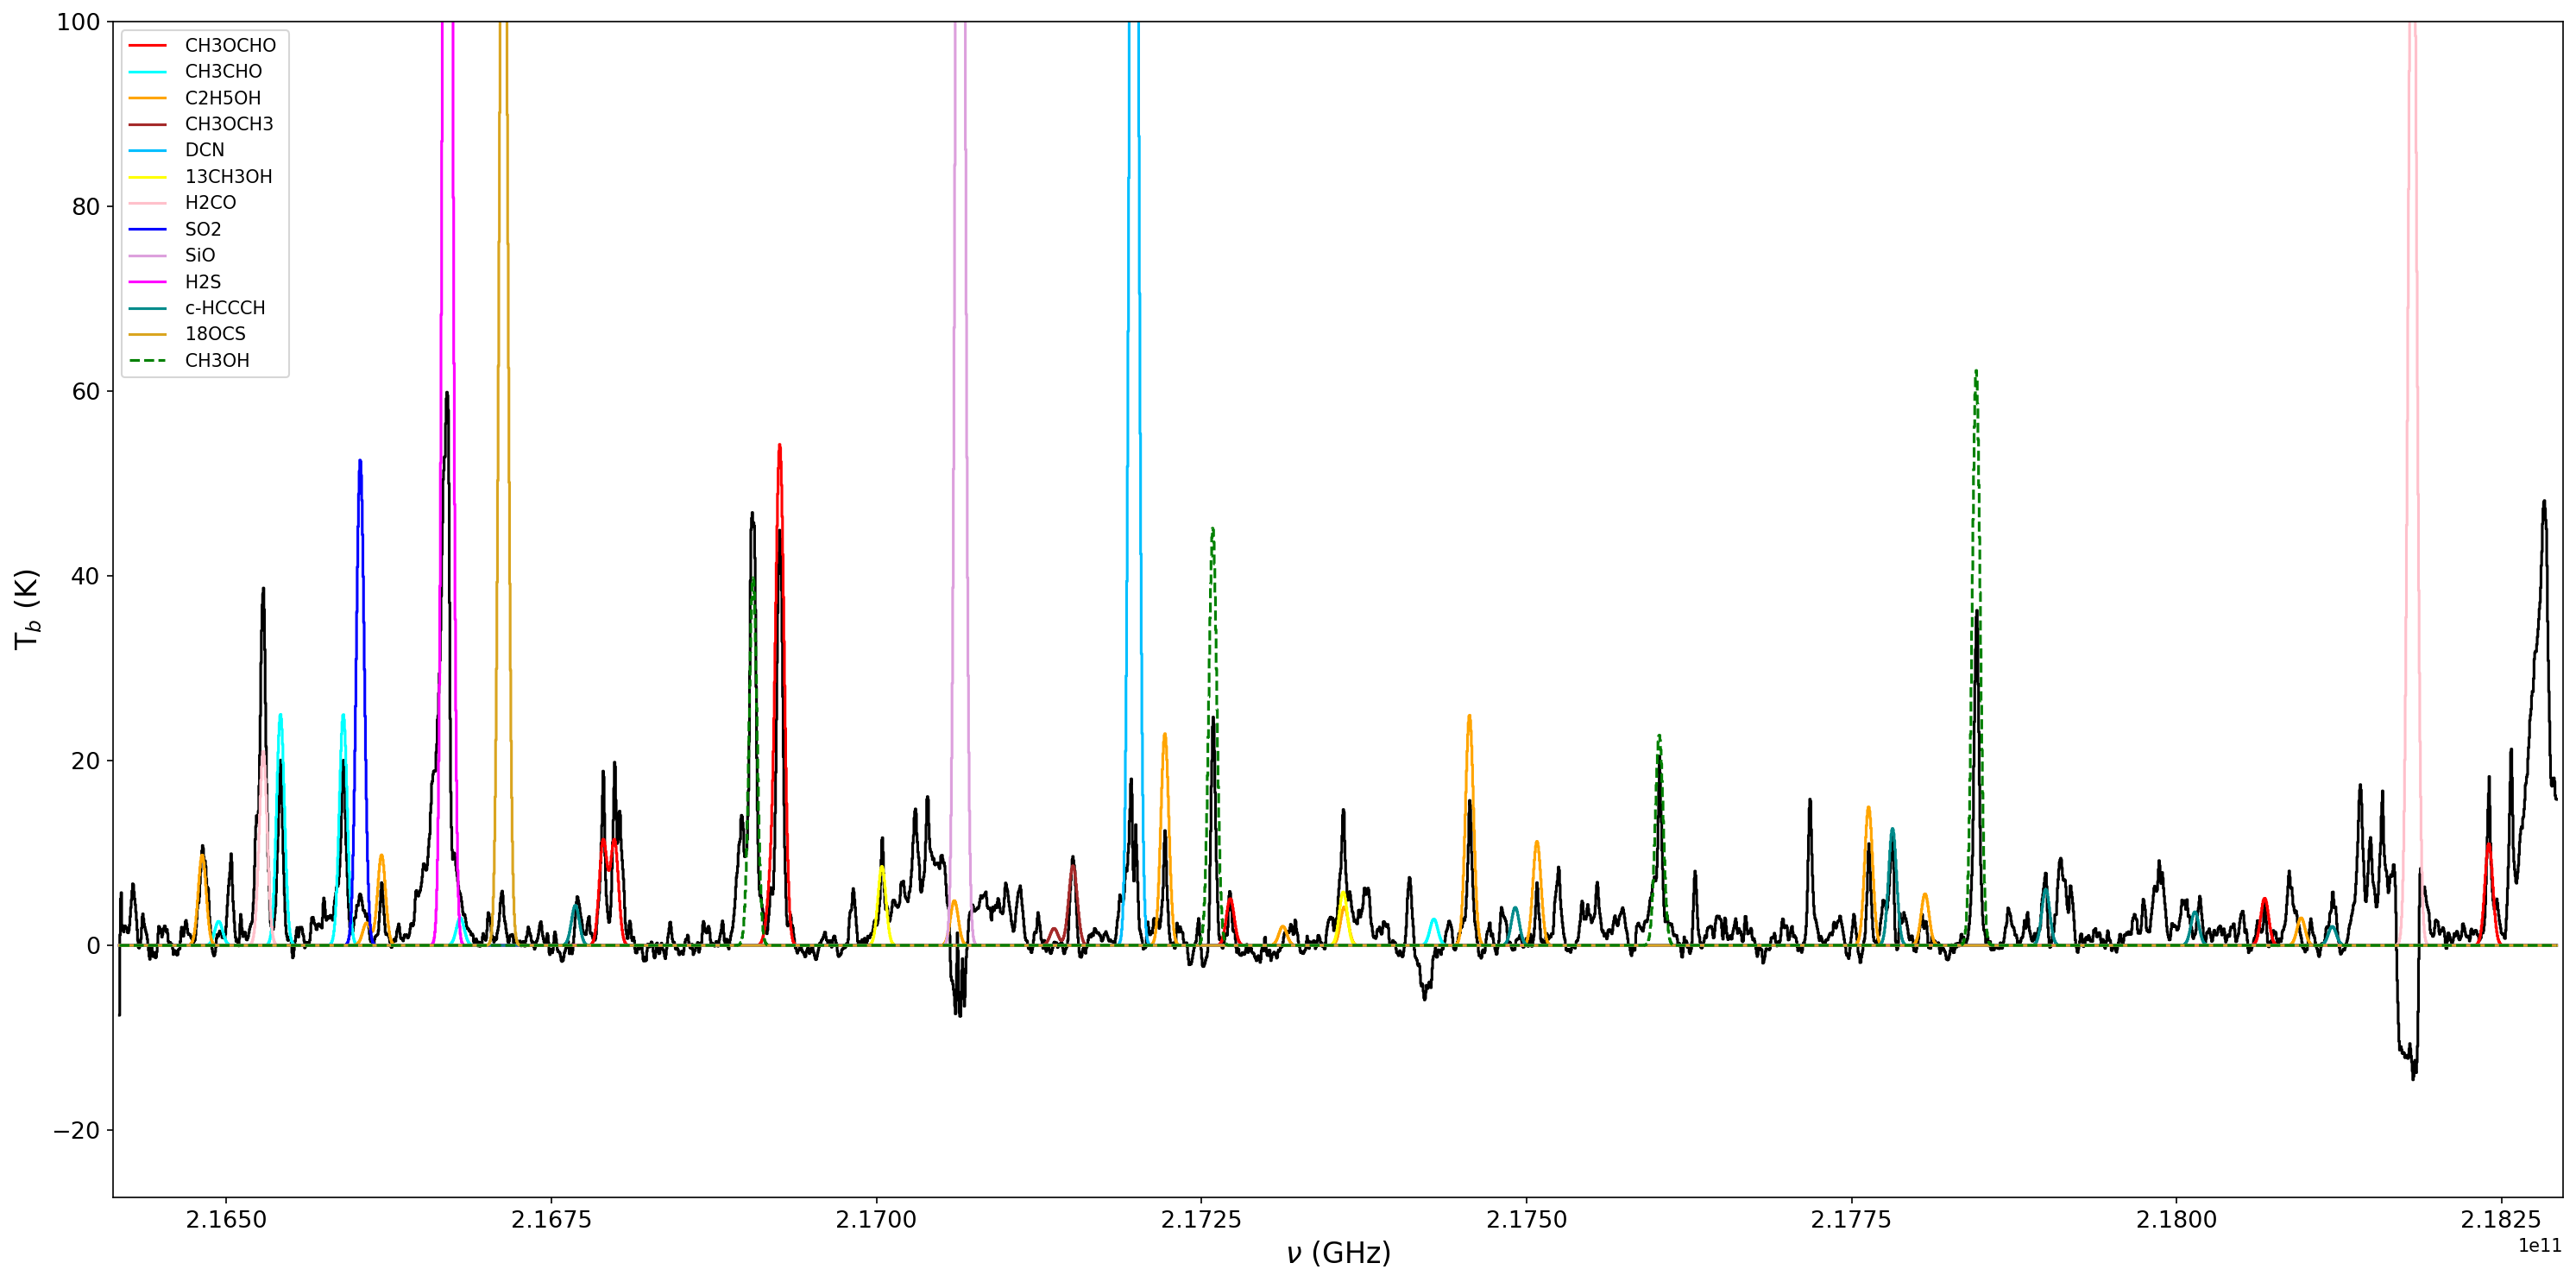

Getting ready - spw1
Corrected decreasing frequency axis
Plotting model spectra
Gathering CDMS table parameters
Begin model loops for  CH3OCHO 
Begin model loops for  CH3CHO 
 C2H5OH  has an incomplete partition function
Estimating by linear fit to log-log Qrot/T relation
Begin model loops for  C2H5OH 
Begin model loops for  CH3OCH3 
No transitions for  DCN  in spw1. Continue
Begin model loops for  OCS 
Begin model loops for  13CH3OH 
Begin model loops for  H2CO 
Begin model loops for  HC3N 
Begin model loops for  C(18)O 
No transitions for  13CS  in spw1. Continue
Begin model loops for  SO2 
Begin model loops for  NH2CHO 
Begin model loops for  HNCO 
Begin model loops for  SO 
No transitions for  SiO  in spw1. Continue
No transitions for  H2S  in spw1. Continue
Begin model loops for  c-HCCCH 
Begin model loops for HC3N v7=1
Begin model loops for  H213CO 
No transitions for  13CH3CN  in spw1. Continue
Begin model loops for  CH2CHCN 
No transitions for  18OCS  in spw1. Continue
Begin mo

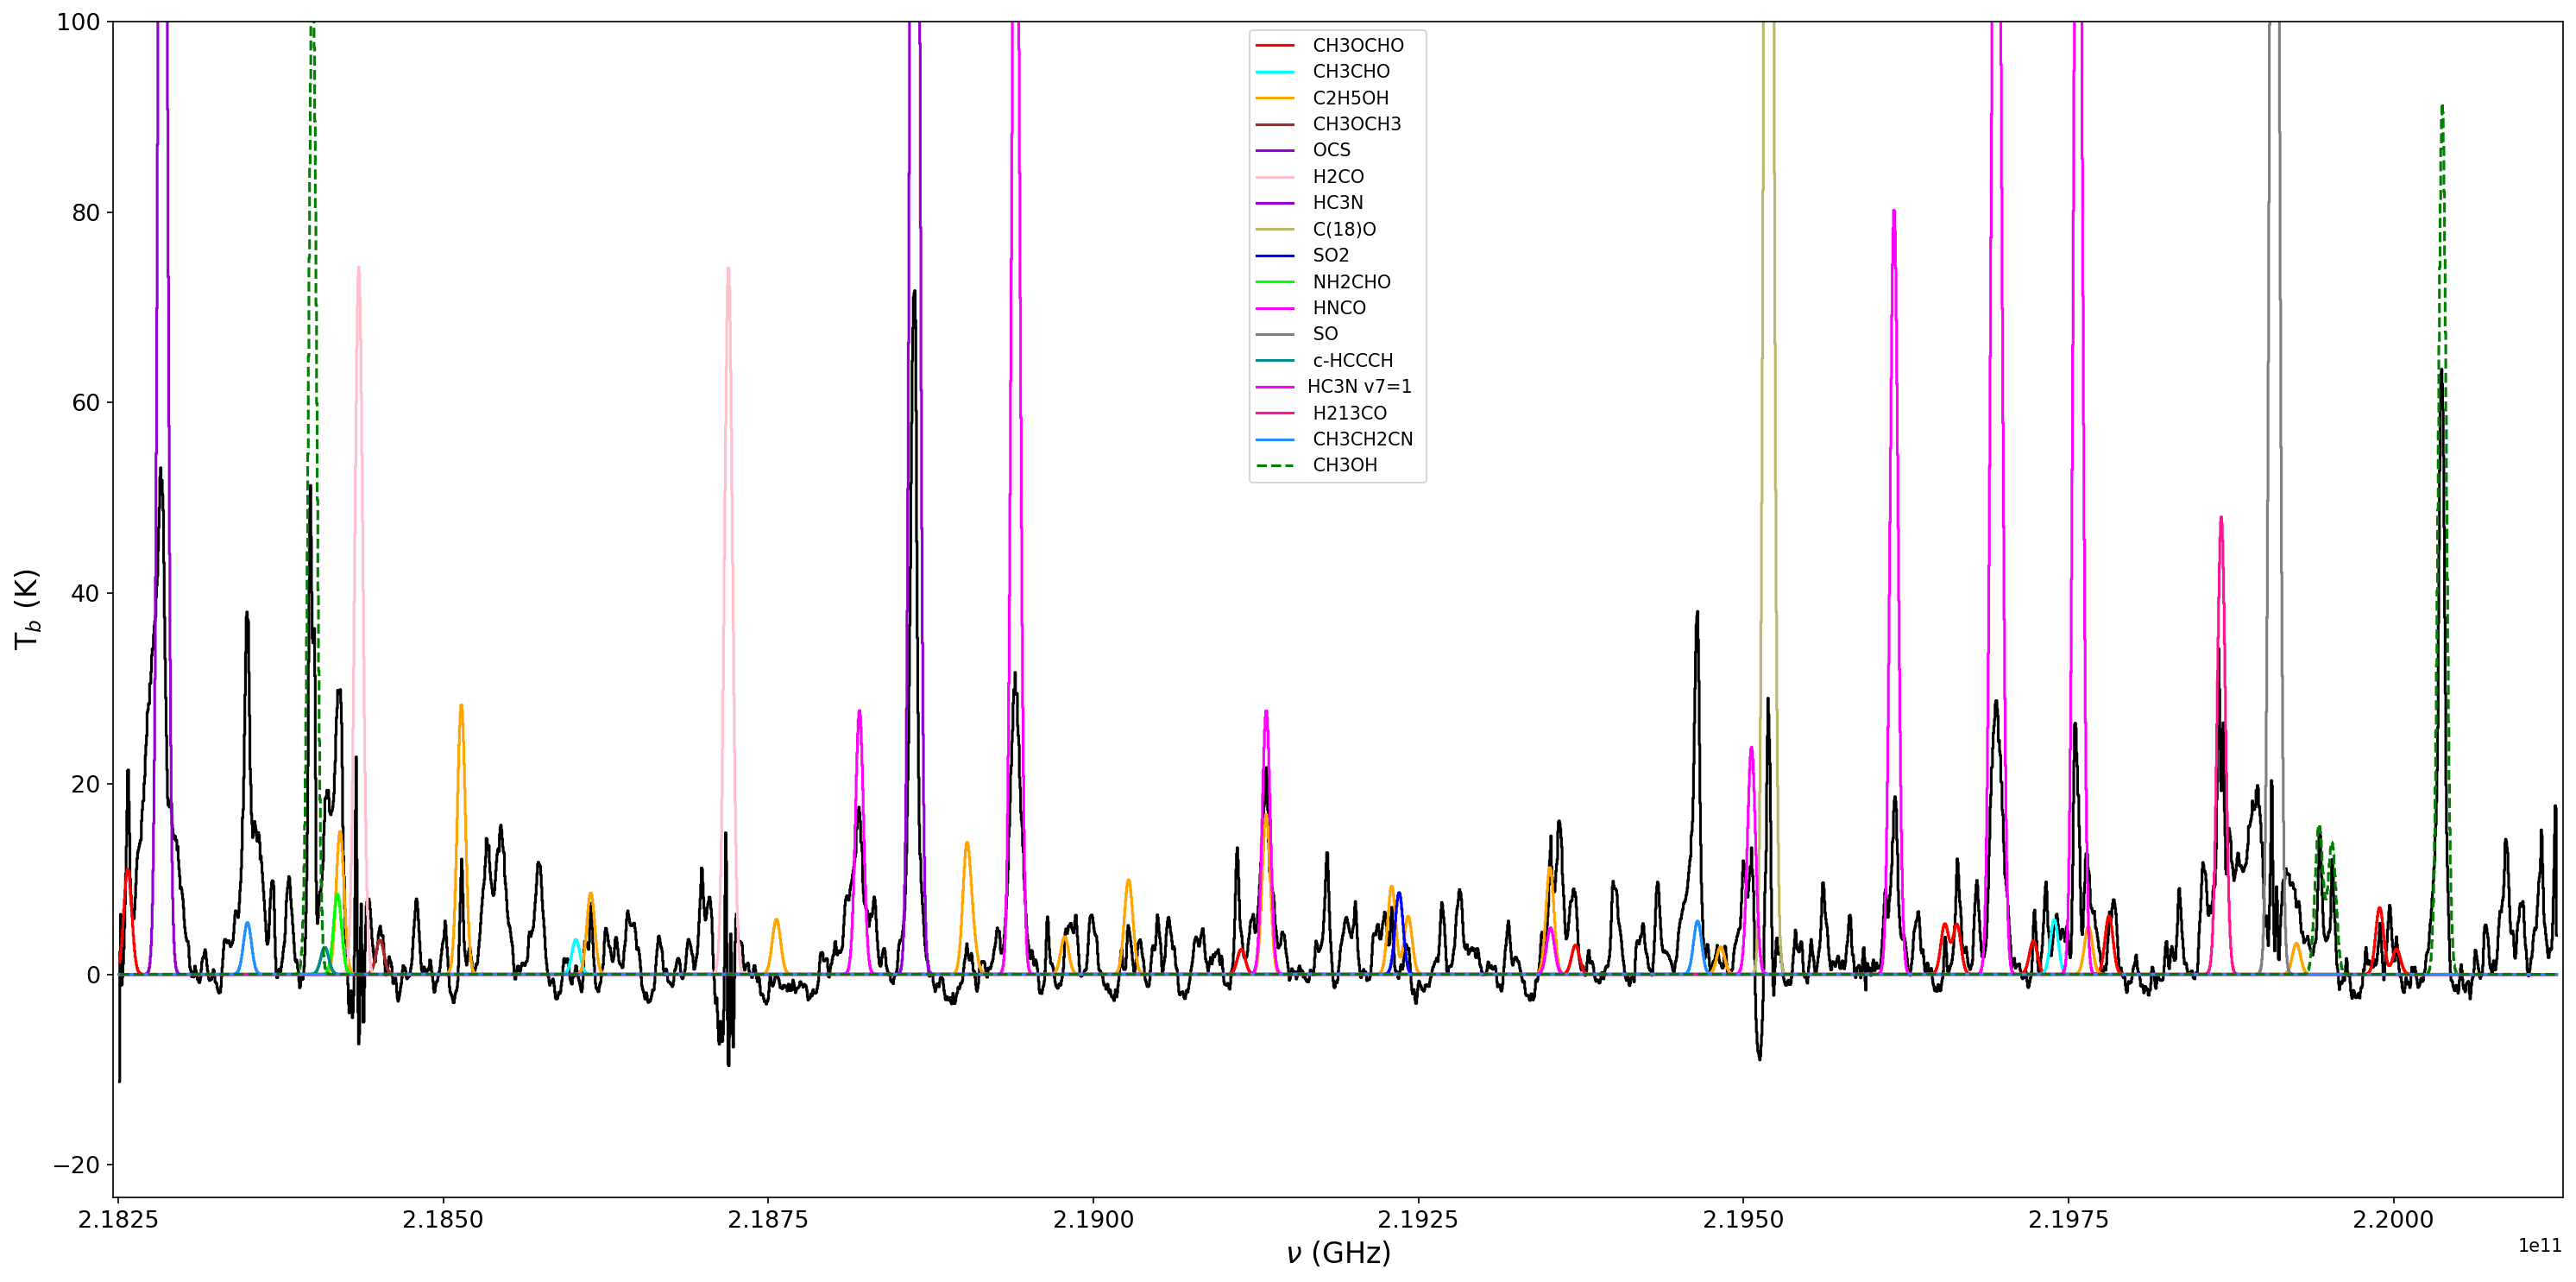

Getting ready - spw2
Plotting model spectra
Gathering CDMS table parameters
Begin model loops for  CH3OCHO 
Begin model loops for  CH3CHO 
 C2H5OH  has an incomplete partition function
Estimating by linear fit to log-log Qrot/T relation
Begin model loops for  C2H5OH 
Begin model loops for  CH3OCH3 
No transitions for  DCN  in spw2. Continue
Begin model loops for  OCS 
Begin model loops for  13CH3OH 
Begin model loops for  H2CO 
No transitions for  HC3N  in spw2. Continue
No transitions for  C(18)O  in spw2. Continue
Begin model loops for  13CS 
Begin model loops for  SO2 
Begin model loops for  NH2CHO 
Begin model loops for  HNCO 
No transitions for  SO  in spw2. Continue
No transitions for  SiO  in spw2. Continue
No transitions for  H2S  in spw2. Continue
Begin model loops for  c-HCCCH 
No transitions for HC3N v7=1 in spw2. Continue
Begin model loops for  H213CO 
Begin model loops for  13CH3CN 
Begin model loops for  CH2CHCN 
No transitions for  18OCS  in spw2. Continue
Begin model lo

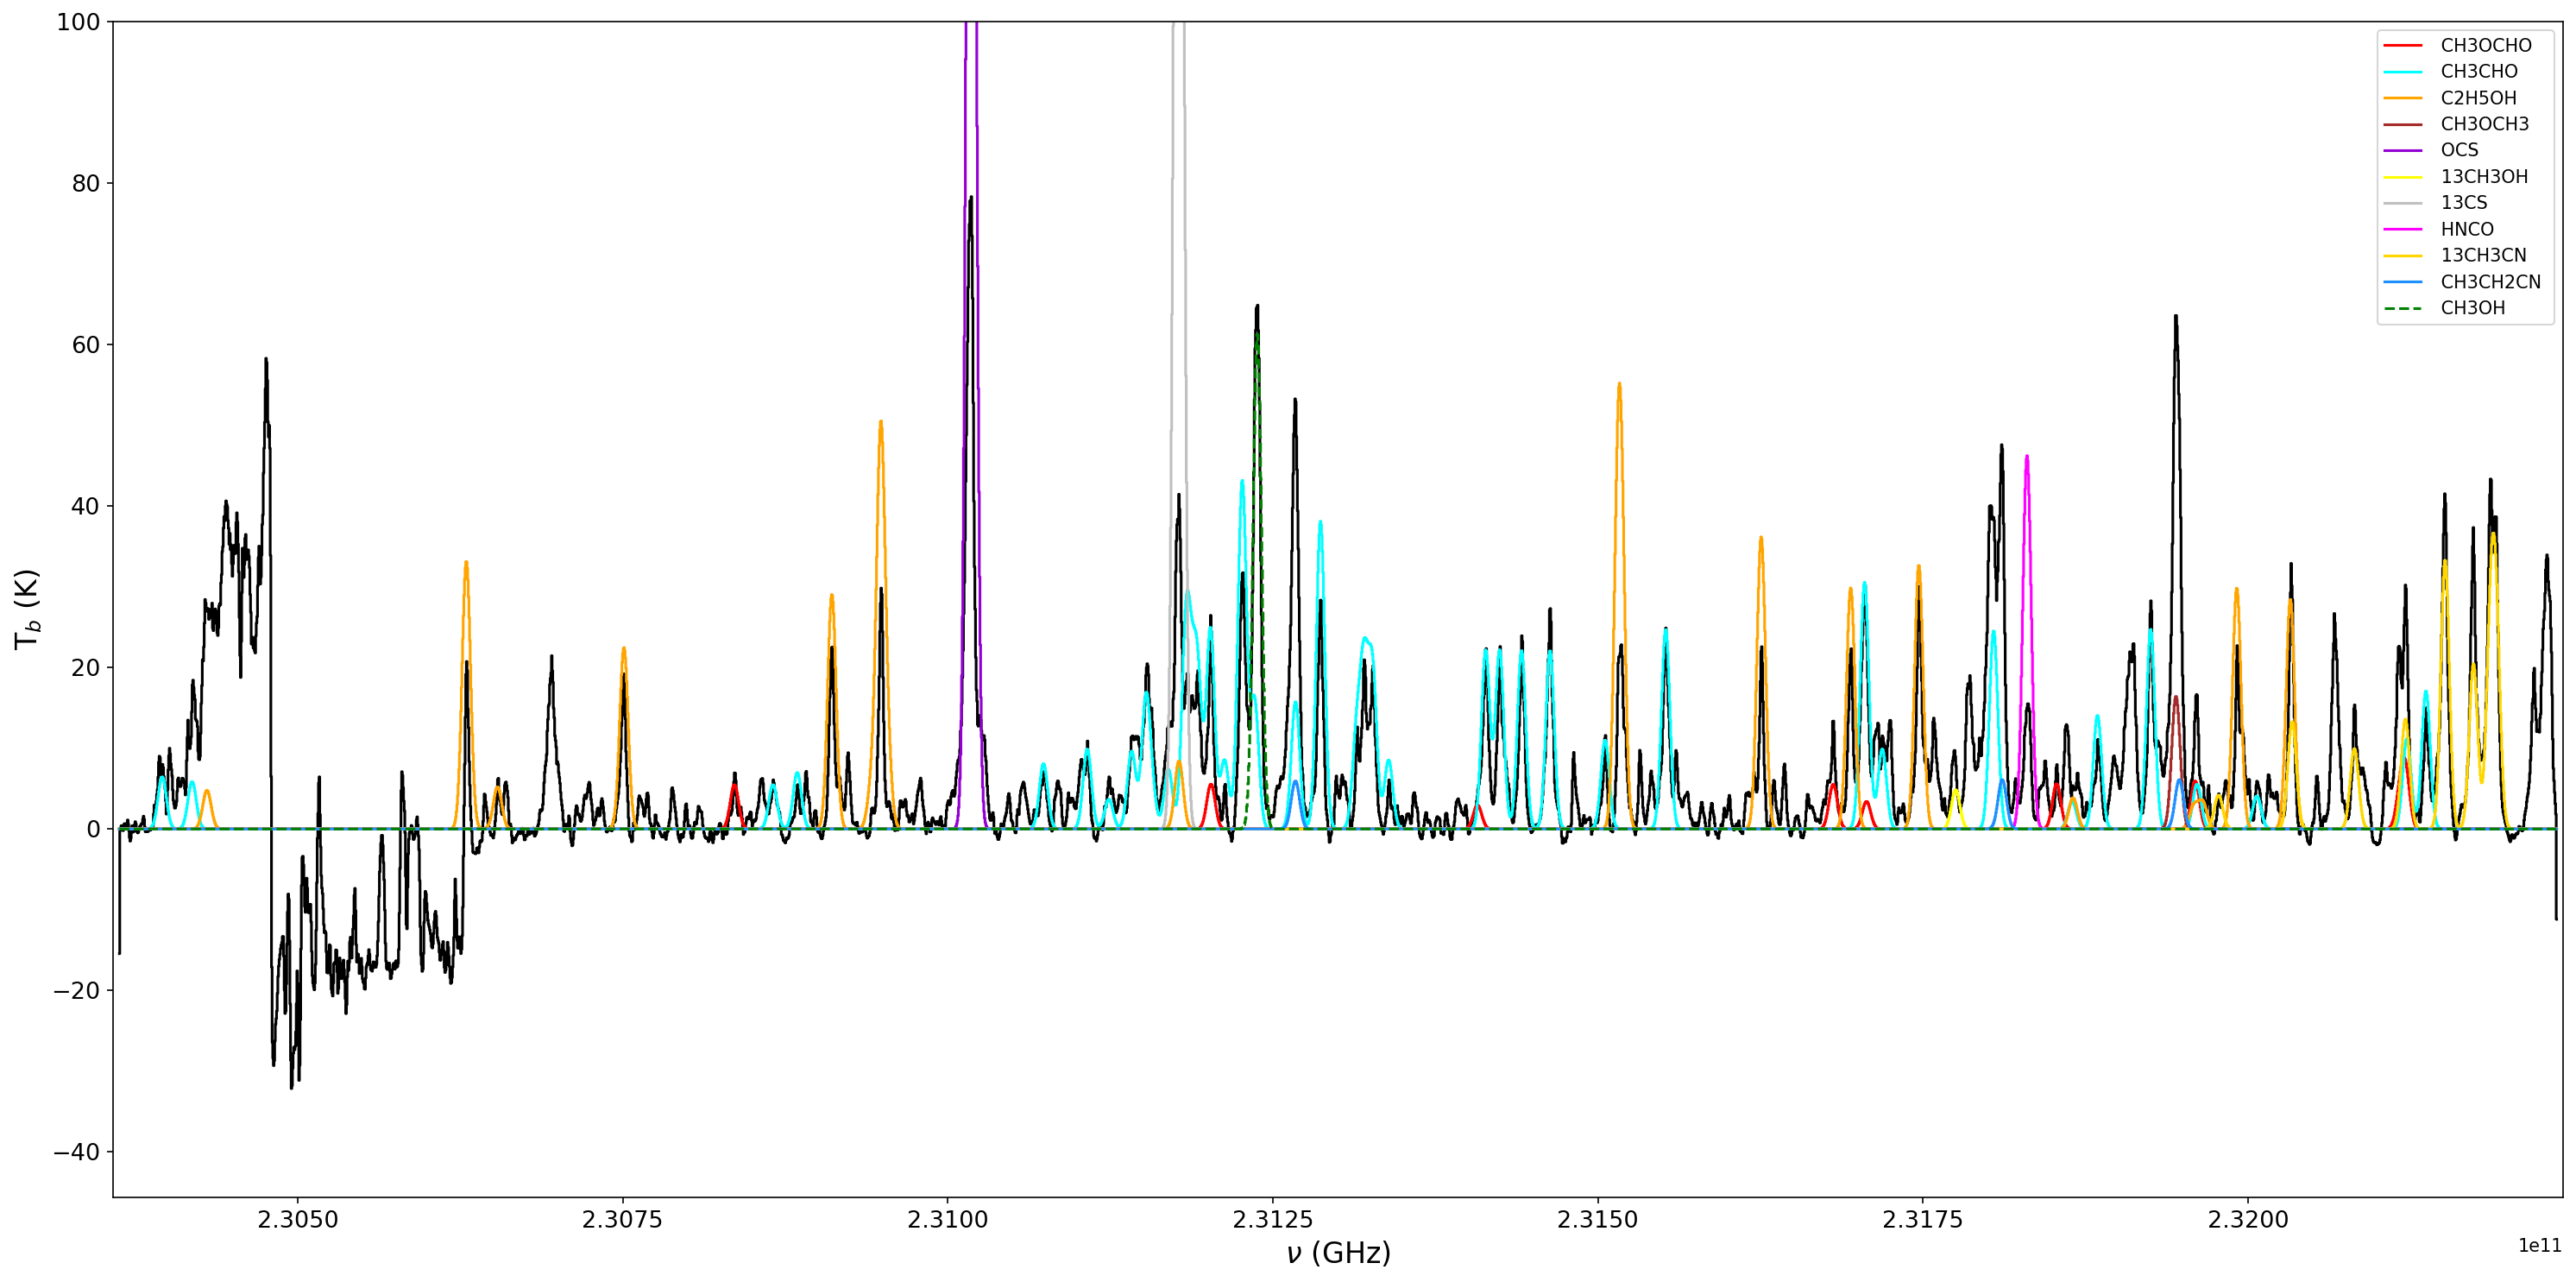

Getting ready - spw3
Plotting model spectra
Gathering CDMS table parameters
Begin model loops for  CH3OCHO 
Begin model loops for  CH3CHO 
 C2H5OH  has an incomplete partition function
Estimating by linear fit to log-log Qrot/T relation
Begin model loops for  C2H5OH 
Begin model loops for  CH3OCH3 
No transitions for  DCN  in spw3. Continue
No transitions for  OCS  in spw3. Continue
Begin model loops for  13CH3OH 
Begin model loops for  H2CO 
No transitions for  HC3N  in spw3. Continue
No transitions for  C(18)O  in spw3. Continue
No transitions for  13CS  in spw3. Continue
Begin model loops for  SO2 
Begin model loops for  NH2CHO 
No transitions for  HNCO  in spw3. Continue
No transitions for  SO  in spw3. Continue
No transitions for  SiO  in spw3. Continue
No transitions for  H2S  in spw3. Continue
Begin model loops for  c-HCCCH 
No transitions for HC3N v7=1 in spw3. Continue
No transitions for  H213CO  in spw3. Continue
No transitions for  13CH3CN  in spw3. Continue
Begin model loop

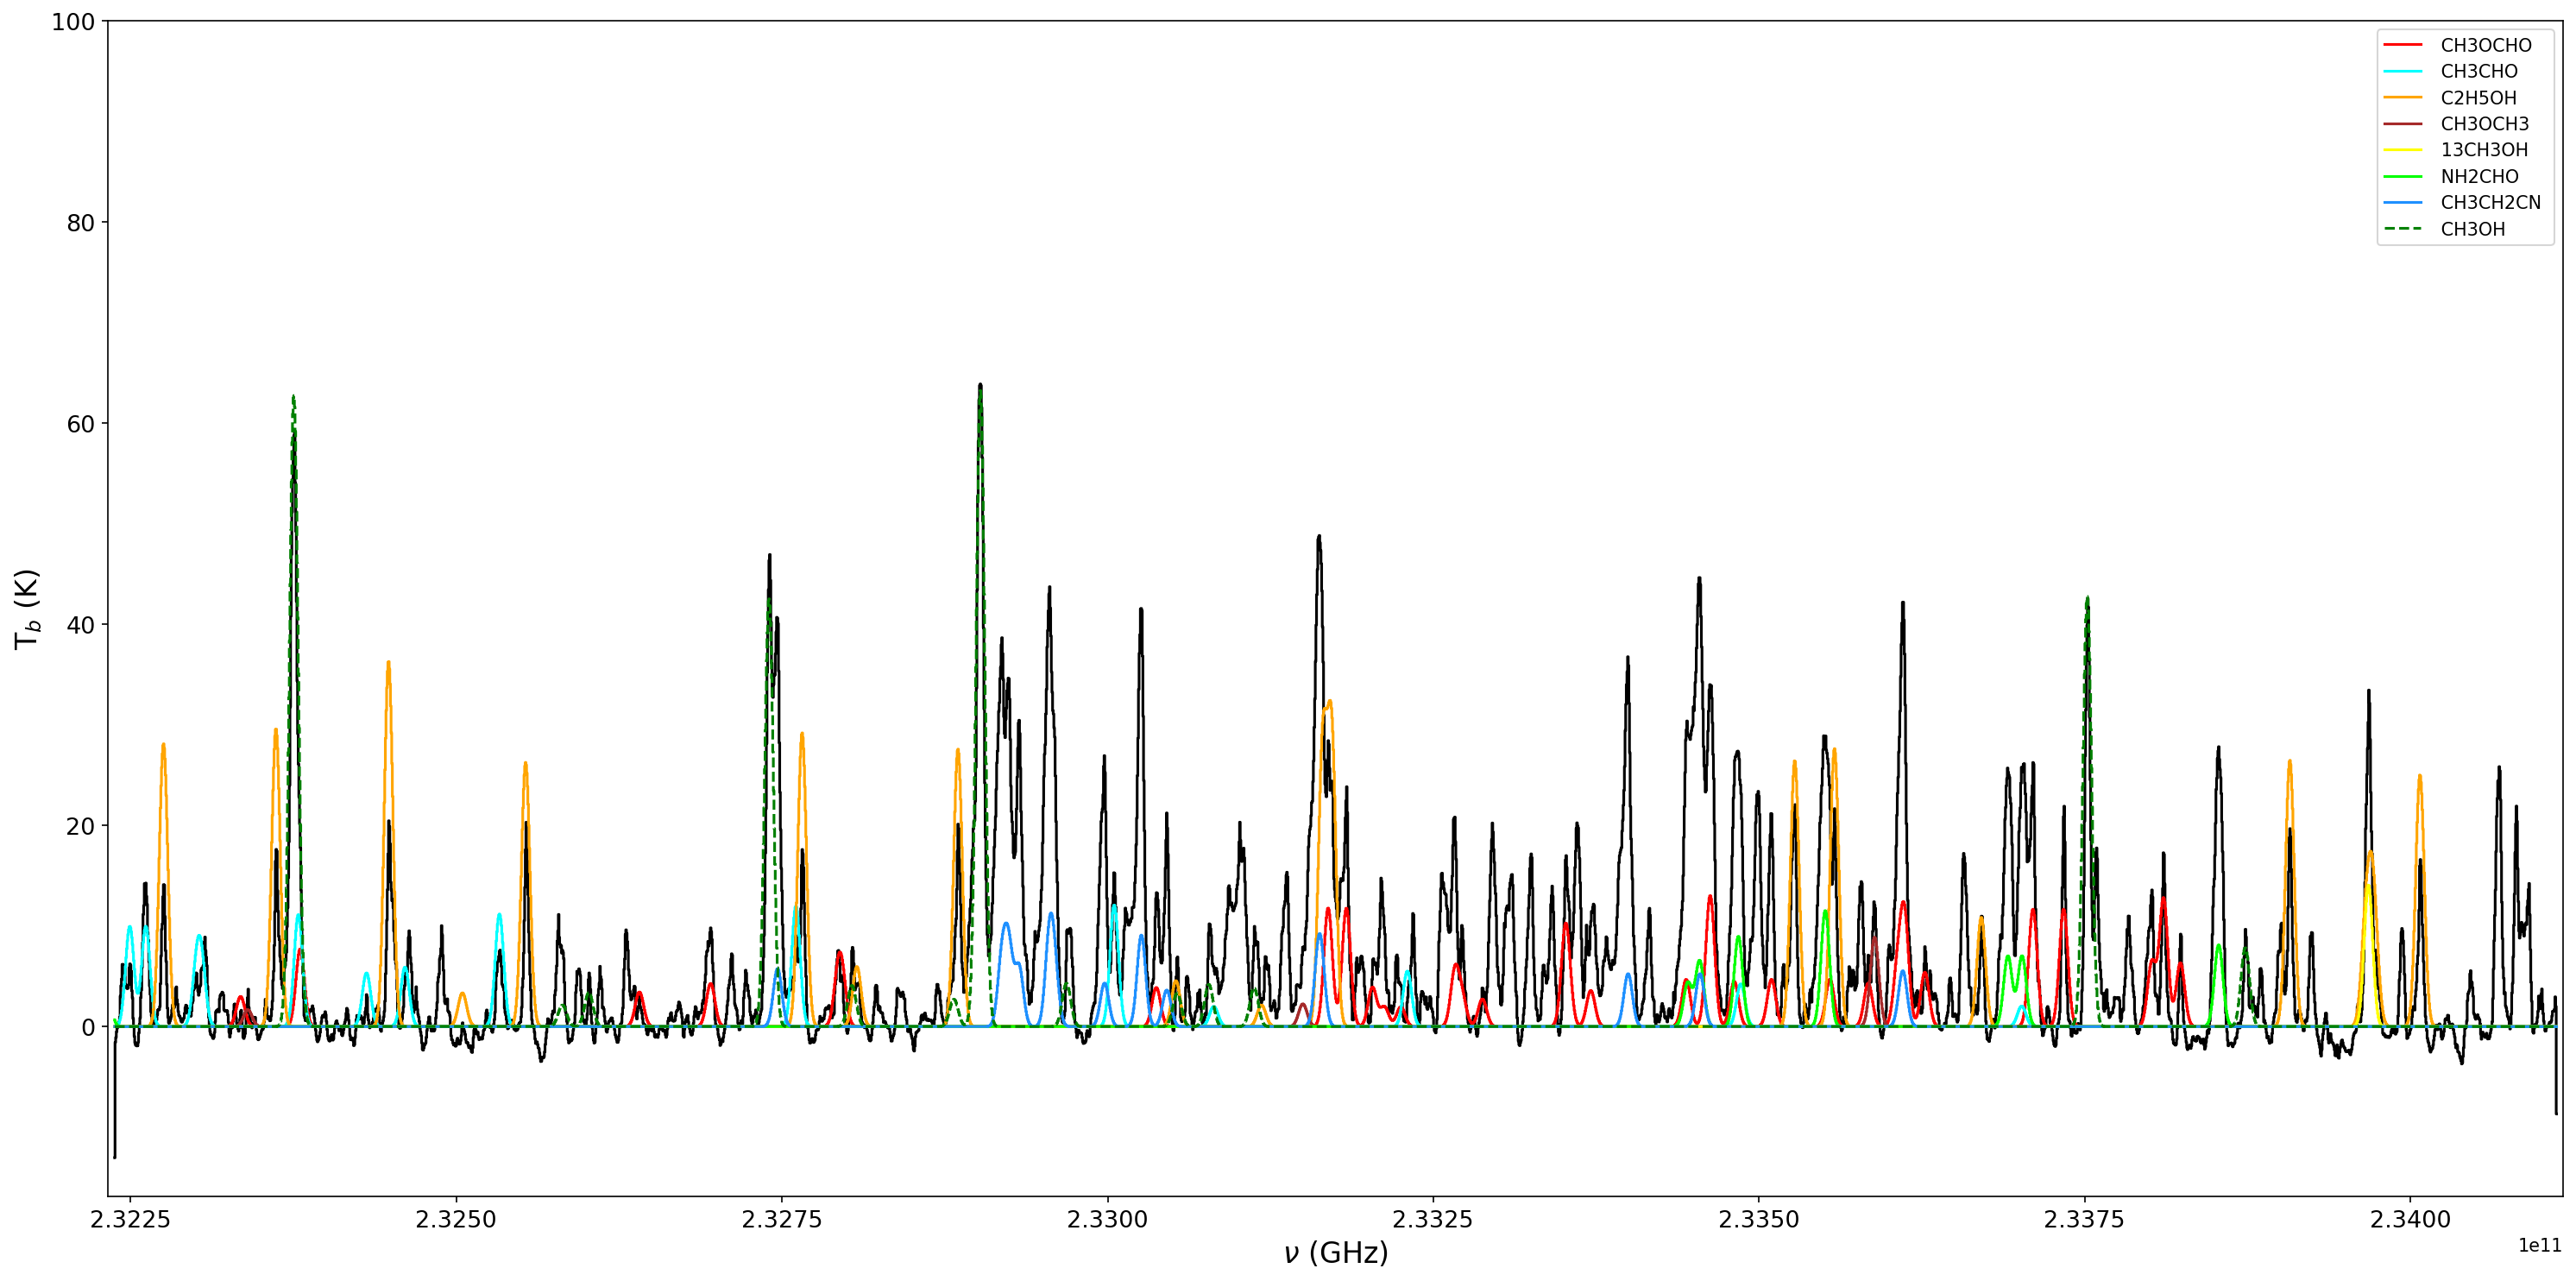

In [1]:
run new_makesyntheticspectra_composite.py